# Applied Data Science Capstone #

## Final Project ##

In this project, neighbourhoods in Toronto, Canada and New York City, USA are compared. The goal is to discover similar neighbourhoods between the two cities in terms of venues/amenities. Location data on neighbourhoods is obtained from sources on the Toronto and New York City Web sites, and venue/amenities data is obtained from Foursquare.

### Library Imports ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopy
import folium
import requests
import urllib
import json

### Toronto Neighbourhood Location Data ###

Data from the Toronto Open Data Portal downloaded in .csv format: https://open.toronto.ca/dataset/neighbourhoods/

In [3]:
df_toronto_neigh = pd.read_csv('TorontoNeighbourhoods.csv')
df_toronto_neigh.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,3641,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
1,3642,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
2,3643,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),NaN,NaN,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{u'type': u'Polygon', u'coordinates': (((-79.3..."
3,3644,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),NaN,NaN,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{u'type': u'Polygon', u'coordinates': (((-79.5..."
4,3645,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),NaN,NaN,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{u'type': u'Polygon', u'coordinates': (((-79.4..."


Clean up the Toronto data

In [4]:
# Keep only the AREA_NAME, latitude and longitude columns
df_toronto_neigh = df_toronto_neigh[['AREA_NAME', 'LATITUDE', 'LONGITUDE']]

# Rename the columns
df_toronto_neigh.rename(columns={'AREA_NAME':'Neighbourhood', 'LATITUDE':'Latitude', 'LONGITUDE':'Longitude'}, inplace=True)

df_toronto_neigh.head()

,Neighbourhood,Latitude,Longitude
0,Wychwood (94),43.676919,-79.425515
1,Yonge-Eglinton (100),43.704689,-79.403590
2,Yonge-St.Clair (97),43.687859,-79.397871
3,York University Heights (27),43.765736,-79.488883
4,Yorkdale-Glen Park (31),43.714672,-79.457108


#### Plot the Toronto neighbourhoods on a map ####

In [5]:
# Function: plotMarkersOnMap
# Plots a set of markers on a map at the given coordinates and with the given popup labels
def plotMarkersOnMap(themap, latitudes, longitudes, labelstrings):
    for lat, lng, label in zip(latitudes, longitudes, labelstrings):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(themap)

In [6]:
# Use the averaged latitude and longitude of the postcodes to get the center point for the map
toronto_long = df_toronto_neigh['Latitude'].mean()
toronto_lati = df_toronto_neigh['Longitude'].mean()

map_toronto = folium.Map(location=[toronto_long, toronto_lati], zoom_start=11)

plotMarkersOnMap(map_toronto, df_toronto_neigh['Latitude'], df_toronto_neigh['Longitude'], df_toronto_neigh['Neighbourhood'])

map_toronto



### New York City Neighbourhood Location Data ###

Data from New York University Spatial Data Repository in GeoJSON format: https://geo.nyu.edu/catalog/nyu_2451_34572

In [7]:
with open('NYCNeighbourhoods.json') as json_data:
    newyork_data = json.load(json_data)

nyc_neigh_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_nyc_neigh = pd.DataFrame(columns=column_names)

# Take data from the JSON formatted source and construc the dataframe
for data in nyc_neigh_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    df_nyc_neigh = df_nyc_neigh.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)

df_nyc_neigh.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Plot the New York neighbourhoods on a map

In [8]:
# Use the averaged latitude and longitude of the postcodes to get the center point for the map
nyc_long = df_nyc_neigh['Latitude'].mean()
nyc_lati = df_nyc_neigh['Longitude'].mean()

map_nyc = folium.Map(location=[nyc_long, nyc_lati], zoom_start=11)

plotMarkersOnMap(map_nyc, df_nyc_neigh['Latitude'], df_nyc_neigh['Longitude'], df_nyc_neigh['Neighbourhood'])

map_nyc

### Foursquare data for Toronto ###

Set Foursqure credentials

In [9]:
CLIENT_ID = '5Q021ZLUNMWQKCCGITLJRJ4KLIUXOQJQBW5A4OWKLS0ZF0VT' # your Foursquare ID
CLIENT_SECRET = 'QH3IR33LI433ODARSKQQWW1YMRVDLXPKC4WBCQM13YOZEPIY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5Q021ZLUNMWQKCCGITLJRJ4KLIUXOQJQBW5A4OWKLS0ZF0VT
CLIENT_SECRET:QH3IR33LI433ODARSKQQWW1YMRVDLXPKC4WBCQM13YOZEPIY


Search parameters

In [10]:
radius = 500
LIMIT = 100

The following function gets venues within each neighbourhood up the radius specified

In [11]:
def getNearbyVenues(neighbourhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for neighbourhood, lat, lng in zip(neighbourhoods, latitudes, longitudes):
        print(neighbourhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response = requests.get(url).json()["response"]
        if "groups" in response:
            response_groups = response['groups']
            if len(response_groups) > 0:
                results = response_groups[0]['items']
        else:
            print('AGGHHH!')
            print(response)
            break
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighbourhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get venues for each neighbourhood in Toronto. Note that this data is saved to a file in the next cell. If you have executed this and the next cell, you can save some time by not running the following cell on subsequent runs and instead just load the file.

In [12]:
df_toronto_venues = getNearbyVenues(neighbourhoods=df_toronto_neigh['Neighbourhood'],
                                   latitudes=df_toronto_neigh['Latitude'],
                                   longitudes=df_toronto_neigh['Longitude']
                                  )
df_toronto_venues.head()

Wychwood (94)
Yonge-Eglinton (100)
Yonge-St.Clair (97)
York University Heights (27)
Yorkdale-Glen Park (31)
Lambton Baby Point (114)
Lansing-Westgate (38)
Lawrence Park North (105)
Lawrence Park South (103)
Leaside-Bennington (56)
Little Portugal (84)
Long Branch (19)
Malvern (132)
Maple Leaf (29)
Markland Wood (12)
Milliken (130)
Mimico (includes Humber Bay Shores) (17)
Morningside (135)
Moss Park (73)
Mount Dennis (115)
Mount Olive-Silverstone-Jamestown (2)
Mount Pleasant East (99)
Mount Pleasant West (104)
New Toronto (18)
Newtonbrook East (50)
Newtonbrook West (36)
Niagara (82)
North Riverdale (68)
North St.James Town (74)
O'Connor-Parkview (54)
Oakridge (121)
Oakwood Village (107)
Old East York (58)
Palmerston-Little Italy (80)
Parkwoods-Donalda (45)
Pelmo Park-Humberlea (23)
Playter Estates-Danforth (67)
Pleasant View (46)
Princess-Rosethorn (10)
Regent Park (72)
Rexdale-Kipling (4)
Rockcliffe-Smythe (111)
Roncesvalles (86)
Rosedale-Moore Park (98)
Rouge (131)
Runnymede-Bloor Wes

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
1,Wychwood (94),43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
2,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Wychwood (94),43.676919,-79.425515,Wychwood Barns Community Gallery,43.679386,-79.424254,Art Gallery
4,Yonge-Eglinton (100),43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym


In [ ]:
# Save the venues info into a files for safe keeping
df_toronto_venues.reset_index().to_csv("TorontoVenues.csv", index=False)

Optionally load the data here from the saved file instead of from Foursquare to save some time

In [13]:
df_toronto_venues = pd.read_csv("TorontoVenues.csv")
df_toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
1,Wychwood (94),43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
2,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Wychwood (94),43.676919,-79.425515,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant
4,Yonge-Eglinton (100),43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym


Run some stats on the Toronto venue data

In [15]:
df_toronto_venues.groupby(['Neighbourhood']).count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North (129),17,17,17,17,17,17
Agincourt South-Malvern West (128),19,19,19,19,19,19
Alderwood (20),5,5,5,5,5,5
Annex (95),27,27,27,27,27,27
Banbury-Don Mills (42),20,20,20,20,20,20


In [16]:
df_toronto_venues.groupby(['Neighbourhood']).count().describe()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,15.343066,15.343066,15.343066,15.343066,15.343066,15.343066
std,18.370948,18.370948,18.370948,18.370948,18.370948,18.370948
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
75%,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


### Foursquare data for New York City ###

Get venues for New York City from Foursquare using the function defined earlier. Note that this data is saved to a file in the next cell. If you have executed this and the next cell, you can save some time by not running the following cell on subsequent runs and instead just load the file.

In [ ]:
df_nyc_venues = getNearbyVenues(neighbourhoods=df_nyc_neigh['Neighbourhood'],
                                   latitudes=df_nyc_neigh['Latitude'],
                                   longitudes=df_nyc_neigh['Longitude']
                                  )
df_nyc_venues.head()

In [ ]:
# Save the venues info into a files for safe keeping
df_nyc_venues.to_csv("NYCVenues.csv", index=False)

Optionally load the data here from the saved file instead of from Foursquare to save some time

In [17]:
df_nyc_venues = pd.read_csv("NYCVenues.csv")
df_nyc_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Run some stats on the New York City venue data, starting with counts

In [18]:
df_nyc_venues.groupby(['Neighbourhood']).count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Allerton,28,28,28,28,28,28
Annadale,10,10,10,10,10,10
Arden Heights,5,5,5,5,5,5
Arlington,6,6,6,6,6,6
Arrochar,19,19,19,19,19,19


In [19]:
df_nyc_venues.groupby(['Neighbourhood']).count().describe()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,34.336667,34.336667,34.336667,34.336667,34.336667,34.336667
std,31.341094,31.341094,31.341094,31.341094,31.341094,31.341094
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
75%,43.250000,43.250000,43.250000,43.250000,43.250000,43.250000
max,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000


### Clustering of Toronto and New York City Neighbourhoods ###

First, combine the Toronto and New York City venue data frames.

In [20]:
# Add in the city names into a column
df_toronto_venues_city = df_toronto_venues.copy().reset_index()
df_toronto_venues_city.insert(0, 'City', 'Toronto')
df_nyc_venues_city = df_nyc_venues.copy().reset_index()
df_nyc_venues_city.insert(0, 'City', 'New York City')

df_venues_comb = df_toronto_venues_city.append(df_nyc_venues_city, ignore_index=True).drop(columns=['index'])
df_venues_comb.head()

,City,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toronto,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
1,Toronto,Wychwood (94),43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
2,Toronto,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Toronto,Wychwood (94),43.676919,-79.425515,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant
4,Toronto,Yonge-Eglinton (100),43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym


#### Venue Category Analysis ####

List out the number of unique venue categories between the two cities.

In [21]:
venue_categories = df_venues_comb['Venue Category'].unique()
print("Number of unique venue categories: ", len(venue_categories))

Number of unique venue categories:  462


This quite a lot of categories to deal with. Inspection of the various categories shows that they can be quite specific, perhaps too specific for our purposes. This can result in a very sparse feature matrix that can make it difficult for clustering. Instead, it would help to have more generic categories, but not so generic such as to lose valuable information about the type of each venue.

Foursquare makes available a heirarchical category listing. This can be used to generalize the venue categories.

First, fetch the heirarchical listing of categories from Foursquare. API documentation and expected response are here: https://developer.foursquare.com/docs/api/venues/categories

In [22]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
response = requests.get(url)
category_data = response.json()['response']['categories']

Define a function that searches through the category heirarchy for a given category, then returns the category that it falls under at the given depth from the top.

In [23]:
def _recursiveParentSearch(name, category, depth=0, parent_depth=0):
    # Check the given category name to see if there is a match
    if "name" in category:
        this_name = category['name']
        #print(this_name, depth)
        if this_name == name:
            #print("Found name! ", this_name, ", Depth=", depth)
            return name

    # If this is not the category, recursively descend through the category heirarchy to find the given category id
    if len(category['categories']) > 0:
        #print(">Decending...")
        for child in category['categories']:
            child_name = _recursiveParentSearch(name, child, depth+1, parent_depth=parent_depth)
            if child_name != None:
                if depth >= parent_depth:
                    return this_name
                else:
                    return child_name
        #print("<Ascending...")
        return None
    else:
        return None
    
def findParentCategory(name, category_data, parent_depth=0):
    for i in range(0, len(category_data)):
        ret_name = _recursiveParentSearch(name, category_data[i], 0, parent_depth)
        if ret_name != None:
            return ret_name
    return None

#print(findParentCategory("Italian Restaurant", category_data, parent_depth=1))

Build a dictionary that list the venue categories with their parent category

In [24]:
venue_cat_dict = {}
for i in range(len(venue_categories)):
    venue_cat_dict.update({venue_categories[i] : findParentCategory(venue_categories[i], category_data, parent_depth=1)})
    
print("Number of parent categories:", len(set(venue_cat_dict.values())))

Number of parent categories: 299


Now add the parent category for each venue

In [25]:
for index, row in df_venues_comb.iterrows():
    df_venues_comb.loc[index, 'Parent Category'] = venue_cat_dict[row['Venue Category']]

df_venues_comb.head()

,City,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,Toronto,Wychwood (94),43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space,Event Space
1,Toronto,Wychwood (94),43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market,Food & Drink Shop
2,Toronto,Wychwood (94),43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park,Park
3,Toronto,Wychwood (94),43.676919,-79.425515,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant,Italian Restaurant
4,Toronto,Yonge-Eglinton (100),43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym,Athletics & Sports


Create a new dataframe with the counts of each type of venue in each neighbourhood

In [57]:
# Get a data frame with one-hot encoding of each venue
df_venue_onehot = pd.get_dummies(df_venues_comb['Parent Category'], prefix="", prefix_sep="")

# Add back the neighbourhood details
df_venue_onehot.insert(0, 'City', df_venues_comb['City'])
df_venue_onehot.insert(1, 'Neighbourhood', df_venues_comb['Neighbourhood'])

# Get the percentage of each type of venue in each neighbourhood.
# This is done by taking the mean of the one-hot encoded columns after grouping by neighbourhood
df_venue_percent = df_venue_onehot.groupby(['City', 'Neighbourhood']).mean().reset_index()

# Another metric is to sum up the number of each type of venue for each neighbourhood
df_venue_counts = df_venue_onehot.groupby(['City', 'Neighbourhood']).sum().reset_index()

df_venue_counts.head()

,City,Neighbourhood,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Waste Facility,Waterfront,Wings Joint,Zoo
0,New York City,Allerton,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York City,Annadale,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York City,Arden Heights,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York City,Arlington,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York City,Arrochar,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now cluster the neighbourhoods using KMeans

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Select the dataframe on which to do the clustering, either the dataframe with the percentages, or the dataframe with the venue counts

In [59]:
df_venues = df_venue_percent
#df_venues = df_venue_counts

Shuffle the rows of the dataframe to mix together Toronto and New York City neighbourhoods. This seems to help with getting a more balanced clustering.

In [68]:
df_venue_random = df_venues.sample(frac=1, random_state=0)

In [78]:
k = 7

X = df_venue_random.drop(['Neighbourhood', 'City'], axis=1)
X_scaled = MinMaxScaler().fit_transform(X)

kmeans_model = KMeans(init = "k-means++", n_clusters=k,  random_state=0)
kmeans_model.fit(X_scaled)

print(kmeans_model.labels_.shape)
kmeans_model.labels_

(437,)


array([0, 1, 0, 1, 2, 1, 1, 1, 4, 6, 1, 1, 1, 1, 1, 6, 6, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 4, 0, 1, 0, 6, 1, 1, 2, 4, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 5, 0, 1, 0, 1, 1, 0, 5, 0, 1, 0, 1,
       0, 0, 0, 4, 5, 4, 2, 0, 1, 2, 4, 1, 2, 0, 0, 1, 1, 1, 5, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 6, 4, 1, 1, 1,
       5, 1, 1, 1, 2, 1, 1, 0, 4, 2, 5, 0, 4, 1, 0, 0, 0, 1, 5, 1, 1, 5,
       1, 0, 1, 1, 1, 5, 2, 0, 1, 5, 1, 1, 2, 4, 1, 0, 2, 1, 6, 5, 1, 0,
       1, 1, 1, 5, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 5,
       1, 0, 5, 1, 1, 4, 1, 1, 0, 0, 1, 1, 4, 1, 2, 0, 0, 1, 1, 5, 1, 1,
       1, 5, 1, 1, 1, 0, 1, 1, 0, 0, 0, 4, 1, 5, 0, 5, 1, 2, 1, 1, 4, 1,
       5, 1, 4, 1, 4, 5, 0, 5, 1, 1, 1, 5, 1, 1, 5, 1, 1, 4, 0, 0, 1, 1,
       1, 0, 1, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 1, 0, 0, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 5, 1, 0, 0, 1, 1, 2, 1, 0, 4, 4,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 5, 2, 1, 6, 0, 2,

Create a new dataframe with the cluster value inserted

In [79]:
df_neigh_clusters = df_venue_random[['City', 'Neighbourhood']].copy()
df_neigh_clusters['Cluster'] = kmeans_model.labels_
df_neigh_clusters.sort_values(by=['City', 'Neighbourhood'], inplace=True)

df_neigh_clusters.head()

,City,Neighbourhood,Cluster
0,New York City,Allerton,0
1,New York City,Annadale,1
2,New York City,Arden Heights,0
3,New York City,Arlington,1
4,New York City,Arrochar,1


Print out all of the neighbourhood in New York City along with their cluster

In [80]:
df_neigh_clusters_nyc = df_neigh_clusters[df_neigh_clusters['City'] == "New York City"].drop(columns=['City'])
df_neigh_clusters_nyc.sort_values(['Cluster', 'Neighbourhood'], inplace=True)
pd.set_option("display.max_rows", 999)
df_neigh_clusters_nyc.head()

,Neighbourhood,Cluster
0,Allerton,0
2,Arden Heights,0
9,Bath Beach,0
28,Borough Park,0
45,Castle Hill,0


### Cluster Analysis ###

Colour scheme for the clusters

In [81]:
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.Set1(np.linspace(1, 0, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#### Basic Cluster Stats ####

First, start off with the number of neighbourhoods in each cluster to help judge how well the neighbourhoods clustered.

City,New York City,Toronto,New York City percent,Toronto percent
Cluster,,,,
0,49,25,16.0,17.9
1,175,72,57.2,51.4
2,31,5,10.1,3.6
3,1,0,0.3,0.0
4,5,23,1.6,16.4


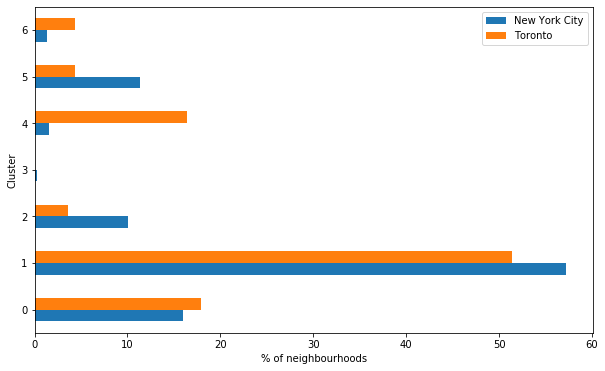

In [82]:
# Create new dataframe with counts and percentages
df_neigh_cnt_clusters = df_neigh_clusters.groupby(['City', 'Cluster'])[['Neighbourhood']].count()['Neighbourhood'].unstack(level=0, fill_value=0)
df_neigh_cnt_clusters['New York City percent'] = round(df_neigh_cnt_clusters["New York City"]/df_nyc_neigh.shape[0]*100, 1)
df_neigh_cnt_clusters['Toronto percent'] = round(df_neigh_cnt_clusters["Toronto"]/df_toronto_neigh.shape[0]*100, 1)

# Now plot the percentages
df_neigh_cnt_clusters[['New York City percent', 'Toronto percent']].plot.barh(figsize=(10,6))
plt.legend(labels=['New York City', 'Toronto'])
plt.xlabel("% of neighbourhoods")

df_neigh_cnt_clusters.head()

Show percentages of neighbourhoods in each cluster

In [83]:
df_neigh_clusters[df_neigh_clusters['City'] == "New York City"].groupby(['City', 'Cluster'])[['Neighbourhood']].count()/df_nyc_neigh.shape[0]*100

Neighbourhood
City          Cluster               
New York City 0            16.013072
              1            57.189542
              2            10.130719
              3             0.326797
              4             1.633987
              5            11.437908
              6             1.307190

In [84]:
df_neigh_clusters[df_neigh_clusters['City'] == "Toronto"].groupby(['City', 'Cluster'])[['Neighbourhood']].count()/df_toronto_neigh.shape[0]*100

Neighbourhood
City    Cluster               
Toronto 0            17.857143
        1            51.428571
        2             3.571429
        4            16.428571
        5             4.285714
        6             4.285714

With 7 clusters, there is a good spead with most neighbourhoods being placed in clusters 0 and 1. Note that Toronto does not have any neighbourhoods in cluster 3, but New York City has only one neighbourhood in this cluster. Which neighbourhood is this?

In [85]:
df_neigh_clusters[df_neigh_clusters['Cluster'] == 3]

,City,Neighbourhood,Cluster
290,New York City,Williamsbridge,3


Average total venue count per neighbourhood in each cluster

In [86]:
print(df_neigh_clusters.shape)
print(df_venue_counts.shape)
df_venue_counts_clustered = df_neigh_clusters.merge(df_venue_counts, on=['City', 'Neighbourhood'])

df_venue_counts_clustered.groupby(['City', 'Cluster']).sum().sum(axis=1)

(437, 3)
(437, 301)


City           Cluster
New York City  0          1239.0
               1          5494.0
               2           551.0
               3             5.0
               4            18.0
               5          2913.0
               6            81.0
Toronto        0           252.0
               1          1355.0
               2            62.0
               4            79.0
               5           292.0
               6            62.0
dtype: float64

There appears to be some consistency in the trends between Toronto and New York City in the number of venues in clusters 0, 1, and 5. Note the Toronto does not have any neighbourhoods in cluster 3.

Compute the average number of venues in each cluster's neighbourhoods

In [87]:
df_venue_avgcnt_clustered = df_venue_counts_clustered.groupby(['City', 'Cluster']).sum().sum(axis=1)/df_neigh_clusters.groupby(['City', 'Cluster'])['Neighbourhood'].count()
df_venue_avgcnt_clustered

City           Cluster
New York City  0          25.285714
               1          31.394286
               2          17.774194
               3           5.000000
               4           3.600000
               5          83.228571
               6          20.250000
Toronto        0          10.080000
               1          18.819444
               2          12.400000
               4           3.434783
               5          48.666667
               6          10.333333
dtype: float64

City,New York City,Toronto
Cluster,,
0,25.285714,10.080000
1,31.394286,18.819444
2,17.774194,12.400000
3,5.000000,0.000000
4,3.600000,3.434783
5,83.228571,48.666667
6,20.250000,10.333333


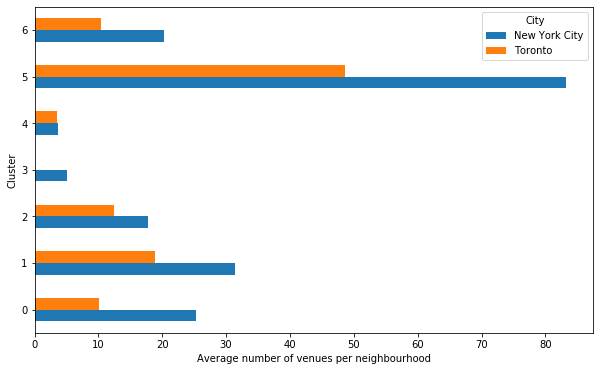

In [88]:
df_venue_avgcnt_clustered = df_venue_counts_clustered.groupby(['City', 'Cluster']).sum().sum(axis=1)/df_neigh_clusters.groupby(['City', 'Cluster'])['Neighbourhood'].count()
df_venue_avgcnt_clustered = df_venue_avgcnt_clustered.unstack(level=0, fill_value=0)
df_venue_avgcnt_clustered.plot.barh(figsize=(10,6))
plt.xlabel("Average number of venues per neighbourhood")
df_venue_avgcnt_clustered

#### Map the clusters ####

First, merge back in the latitude/logitude data for each neighbourhood

In [89]:
# This function places markers on the map for each cluster in different colours
def plotClusterMarkersOnMap(themap, df, cluster_colours):
    for lat, lng, label, clus in zip(df['Latitude'], df['Longitude'], df['Neighbourhood'], df['Cluster']):
        label = folium.Popup(str(clus) + ": " + label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=cluster_colours[clus],
            fill=True,
            fill_color=cluster_colours[clus],
            fill_opacity=0.7,
            parse_html=False).add_to(themap)

Create a legend

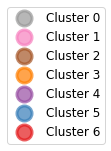

In [90]:
from matplotlib.lines import Line2D

legend_elements = []
for i in range(0, k):
    legend_elements.append(Line2D([0],[0], markeredgecolor=rainbow[i], mew=3, lw=0, alpha=0.7, marker='o', markersize=15, markerfacecolor=rainbow[i], label="Cluster " + str(i)))

fig, ax = plt.subplots(figsize=(1,1))
plt.axis('off')
ax.legend(handles=legend_elements, loc='center', fontsize=12)
plt.show()

In [91]:
# Merge back in the latitude/longitude for NYC neighbourhoods
df_nyc_neigh_clusters = df_neigh_clusters[df_neigh_clusters['City'] == "New York City"]
df_nyc_neigh_clusters = df_nyc_neigh_clusters.merge(df_nyc_neigh, on=['Neighbourhood'])

# Produce the map
map_nyc_clusters = folium.Map(location=[nyc_long, nyc_lati], zoom_start=11)
plotClusterMarkersOnMap(map_nyc_clusters, df_nyc_neigh_clusters, rainbow)
print("New York City")
map_nyc_clusters

New York City


In [94]:
# Merge back in the latitude/longitude for NYC neighbourhoods
df_toronto_neigh_clusters = df_neigh_clusters[df_neigh_clusters['City'] == "Toronto"]
df_toronto_neigh_clusters = df_toronto_neigh_clusters.merge(df_toronto_neigh, on=['Neighbourhood'])

# Produce the map
map_toronto_clusters = folium.Map(location=[toronto_long, toronto_lati], zoom_start=11)
plotClusterMarkersOnMap(map_toronto_clusters, df_toronto_neigh_clusters, rainbow)
print("Toronto")
map_toronto_clusters

Toronto


Find the most common venue types in each cluster

Cluster 0 
Pizza Place          0.102988
Pharmacy             0.086047
Food & Drink Shop    0.063996
Asian Restaurant     0.061371
Coffee Shop          0.042094
dtype: float64 

Cluster 1 
Asian Restaurant      0.061023
Athletics & Sports    0.056274
Food & Drink Shop     0.054801
Pizza Place           0.038566
Bar                   0.036455
dtype: float64 

Cluster 2 
Food & Drink Shop       0.097595
Caribbean Restaurant    0.072830
Fried Chicken Joint     0.059516
Asian Restaurant        0.054493
Athletics & Sports      0.043013
dtype: float64 

Cluster 3 
Spa                     0.2
Soup Place              0.2
Bar                     0.2
Nightclub               0.2
Caribbean Restaurant    0.2
dtype: float64 

Cluster 4 
Park                  0.478061
Playground            0.069643
Athletics & Sports    0.069218
Dog Run               0.029762
Moving Target         0.027381
dtype: float64 

Cluster 5 
Bar                   0.086900
Asian Restaurant      0.076392
Athletics & Sports    

Restaurant            0.117431
Asian Restaurant      0.070645
Athletics & Sports    0.062024
Café                  0.057454
Dessert Shop          0.046667
dtype: float64

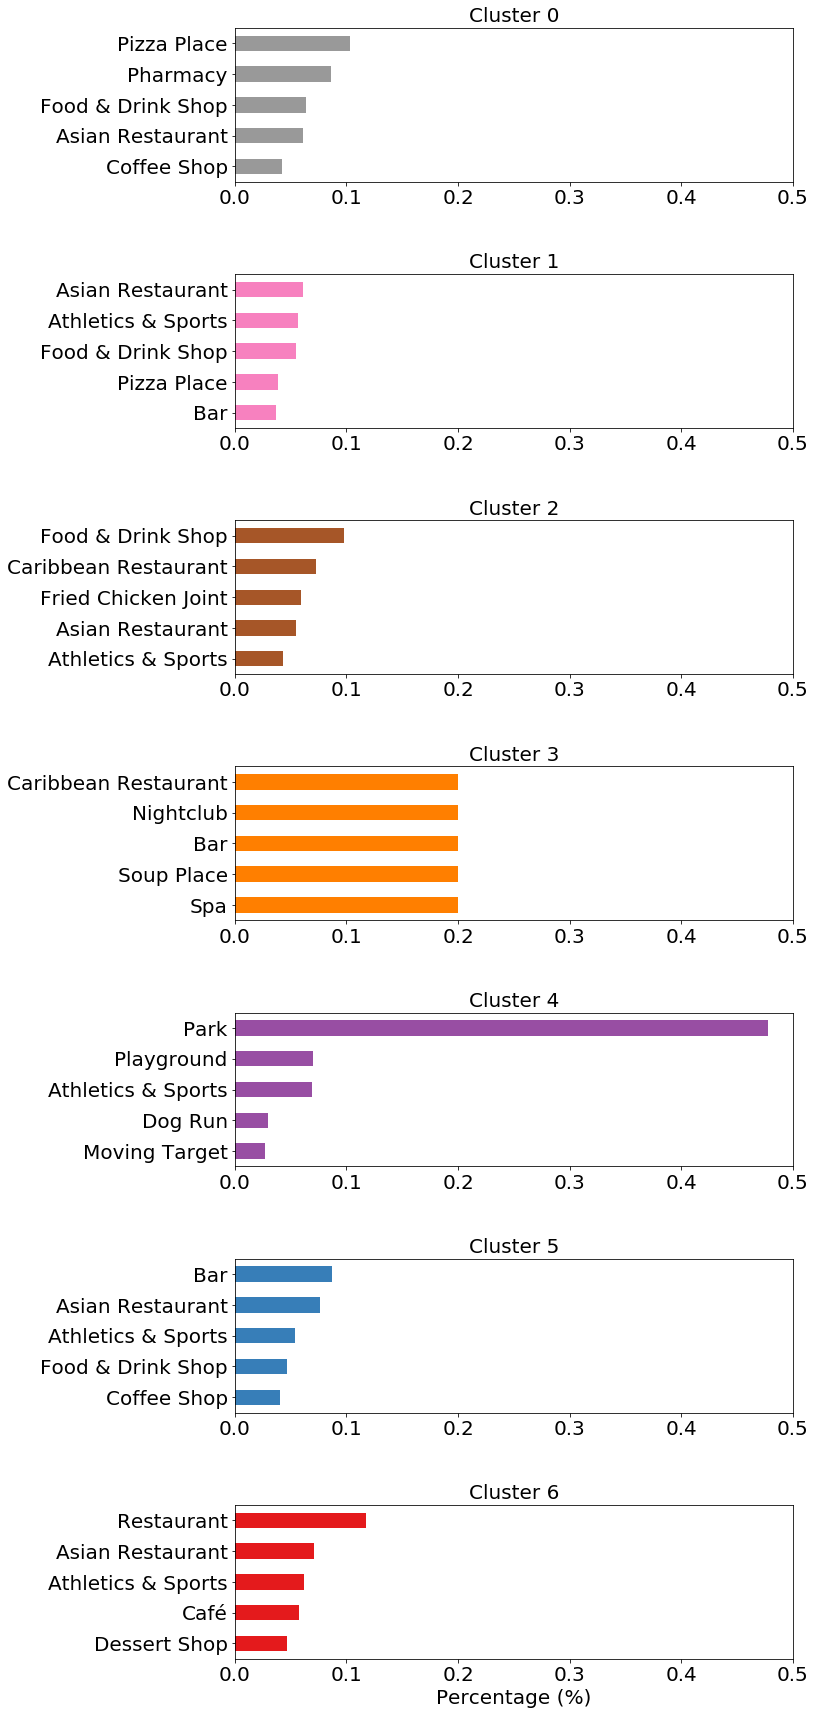

In [95]:
df_venue_clustered = df_neigh_clusters.merge(df_venues, on=['City', 'Neighbourhood'])
fig = plt.figure()
gs = gridspec.GridSpec(k, 1)
gs.update(hspace=0.6)
for i in range(0, k):
    df_temp = df_venue_clustered[df_venue_clustered['Cluster'] == i]
    top_cats = df_temp.drop(['Cluster'], axis=1).mean().sort_values(ascending=False)
    print('Cluster', i, "\n=========")
    print(top_cats.head(5), "\n")
    ax = fig.add_subplot(gs[i])
    top_cats.iloc[0:5].sort_values(ascending=True).plot.barh(ax=ax, figsize=(10, 30), color=rainbow[i])
    ax.set_xlim([0,0.5])
    plt.title('Cluster ' + str(i), fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
plt.xlabel("Percentage (%)", fontsize=20)
top_cats.head()

Let's have a look at Coffee Shops and Cafes to see if there is a distinction. 

In [96]:
df_coffee_venues = df_venues_comb[df_venues_comb["Parent Category"] == "Coffee Shop"][['City', 'Neighbourhood', 'Venue']]
df_coffee_venues_cnt = df_coffee_venues.groupby('Venue').count().drop(columns='Neighbourhood').rename(columns={'City':'Count'}).sort_values('Count', ascending=False)
total_coffee_venues = df_coffee_venues_cnt.shape[0]
df_coffee_venues_cnt['Percentage'] = round(df_coffee_venues_cnt['Count']/total_coffee_venues*100, 1)
print("Number of unique coffee venues:", total_coffee_venues)
df_coffee_venues_cnt.head()

Number of unique coffee venues: 240


,Count,Percentage
Venue,,
Starbucks,78,32.5
Tim Hortons,62,25.8
Blue Bottle Coffee,10,4.2
Second Cup,9,3.8
Hungry Ghost,6,2.5


In [97]:
df_cafe_venues = df_venues_comb[df_venues_comb["Parent Category"] == "Café"][['City', 'Neighbourhood', 'Venue']]
df_cafe_venues_cnt = df_cafe_venues.groupby('Venue').count().drop(columns='Neighbourhood').rename(columns={'City':'Count'}).sort_values('Count', ascending=False)
total_cafe_venues = df_cafe_venues_cnt.shape[0]
df_cafe_venues_cnt['Percentage'] = round(df_cafe_venues_cnt['Count']/total_cafe_venues*100, 1)
print("Number of unique coffee venues:", total_cafe_venues)
df_cafe_venues_cnt.head()

Number of unique coffee venues: 228


,Count,Percentage
Venue,,
Bluestone Lane,7,3.1
Aroma Espresso Bar,4,1.8
Gotan,4,1.8
Maman,3,1.3
Thobors Boulangerie Patisserie Café,2,0.9


## Discussion and Analysis ##

### General observations ###
1. Five of the seven clusters have Asian Restaurants in their top five venue types, with cluster 1 having the highest proportion compared to other venues types in that cluster.
1. Athetics & Sports venues show up in the top 5 in five out of the seven clusters.
1. Neighbourhoods in all cluster except for Cluster 5 appear to be spread out geographically in both Toronto and New York City. Most Cluster 5 neighbourhoods are geographically close to the city centres. 

### Cluster-specifics ###

#### Cluster 0 ####
Pizza Places dominate these neighbourhoods with an average of over 10% of the venues in each neighbourhood being Pizza Places. 

#### Cluster 1 ####
This cluster has the largest number of neighbourhoods. Asian restaurants lead in this cluster by a slight margin. The overall proportion of the top 5 categories is lower than in other clusters, suggesting that the top 5 venue categories in Cluster 1 do not dominate and that there is a more balanced mix of other venue types in these neighbourhoods.

#### Cluster 2 ####
Cluster 2 is dominated by Food and Drink Shops (e.g. grocery stores, wine stores, etc.). Carribean Restaurants are the dominant restaurant type.

#### Cluster 3 ####
As discovered previously, Cluster 3 has only one neighbourhood in it, Williamsbridge. There were only 5 venues in this neighbourhood, all of different types.

#### Cluster 4 ####
Parks are very dominant in this cluster. There are no food or drink venues in this cluster's top 5. Contrary to the trend in other clusters, Toronto has more neighbourhoods in Cluster 4 than does New York City.

#### Cluster 5 ####
This cluster shares a similar venue mix in it's top 5 venue types as in Cluster 1. However, the proportions of each venue type is in a different order with bars being the lead venue type. Also, the overall proportions of the top 5 are larger than in Cluster 1, suggesting that the proportions of other venues type below the top 5 are lower. 

#### Cluster 6 ####
Four of the five venue categories in Cluster 6 are food and drink venues. The generic "Restaurant" venue category dominates, which is somewhat ambiguous and not specific enough to draw good conclusions about the mix of restaurant types.
